# Game Flow Incorporating Momentum
Takes in the game flow array of probabilities and modifies them according to various explanatory variables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools # for shortening double-loop code.
%matplotlib inline
plt.style.use('ggplot')

import tennis_data
import dynamic_model1 as dm1

/home/moo/projects/Tennis-Data-Analysis-Research/dynamic_model1.py:483: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


Predicted winner at set 2 correctly 24 / 31 times
Predicted winner at set 3 correctly 24 / 31 times
Predicted winner at set 4 correctly 28 / 30 times
Predicted winner at set 5 correctly 15 / 18 times
Predicted winner at set 5 correctly 5 / 7 times


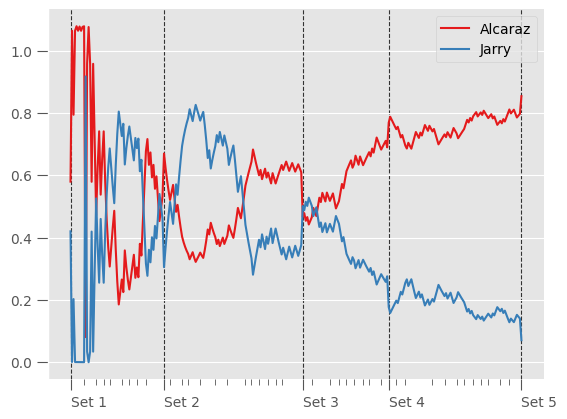

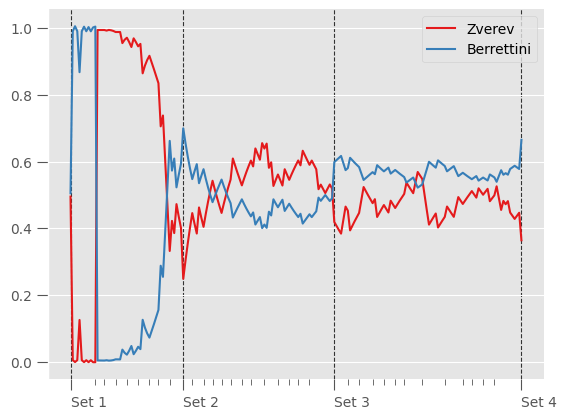

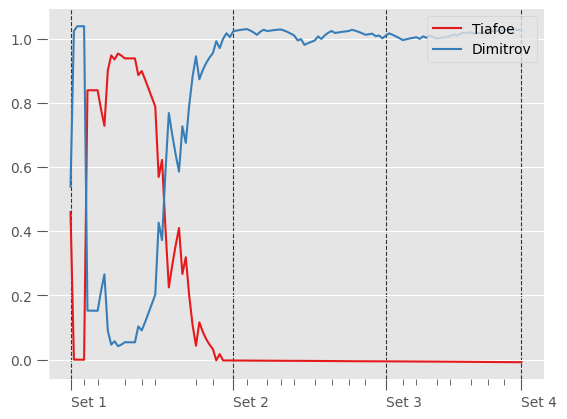

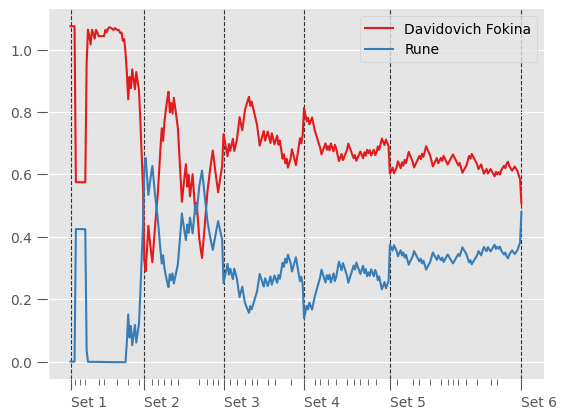

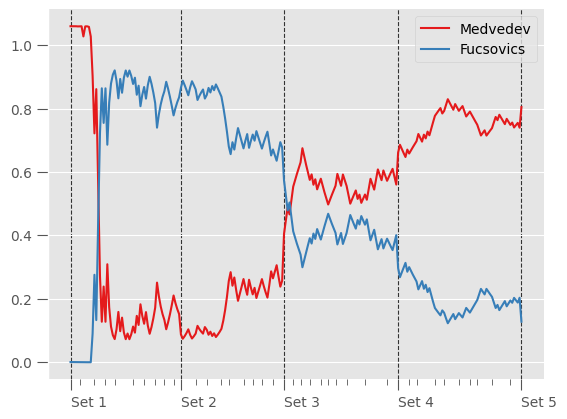

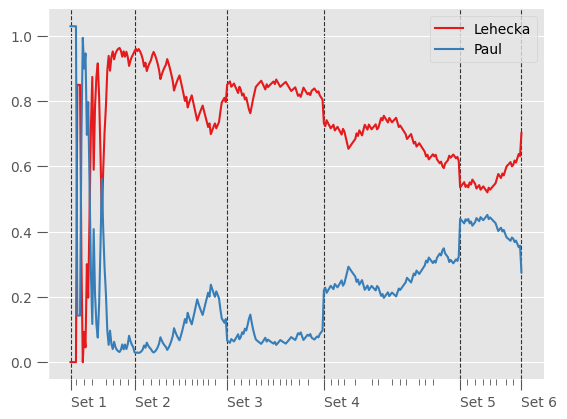

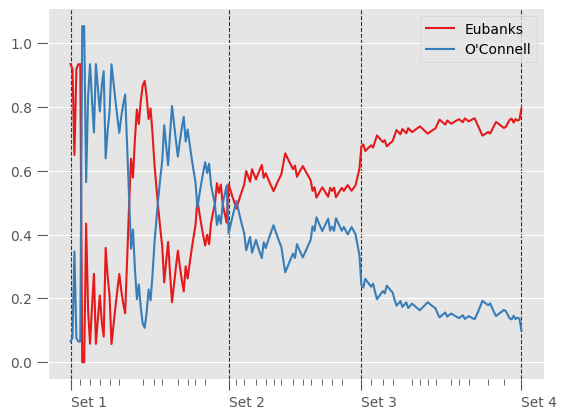

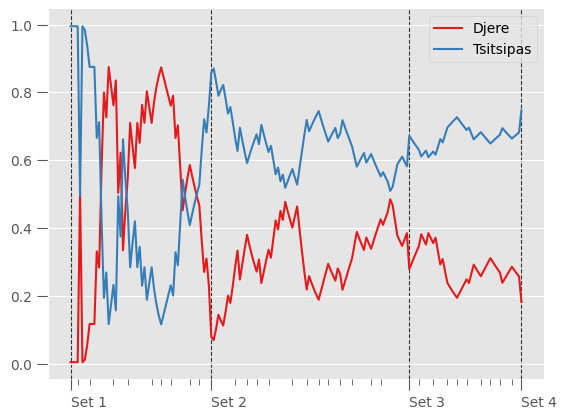

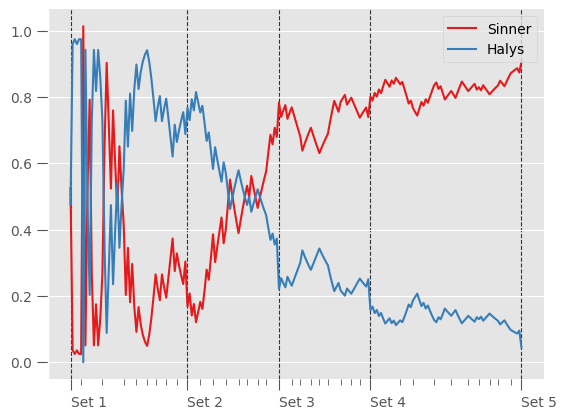

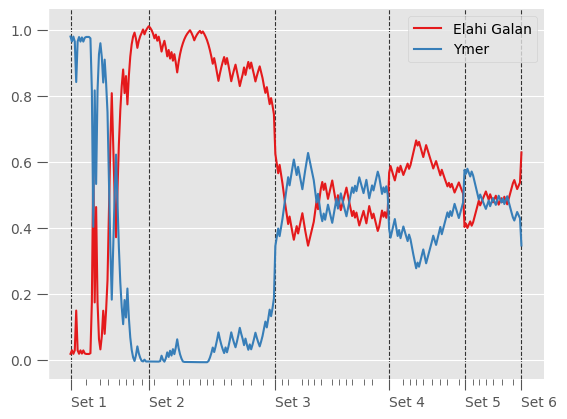

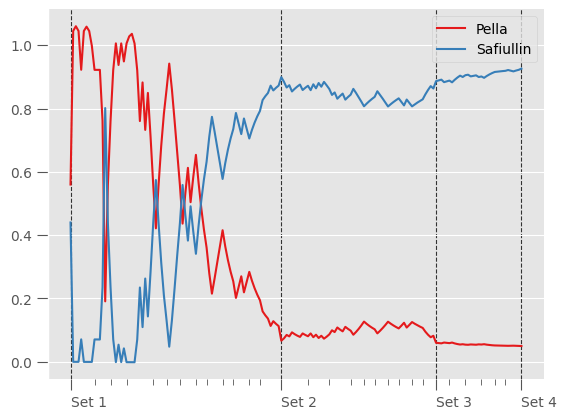

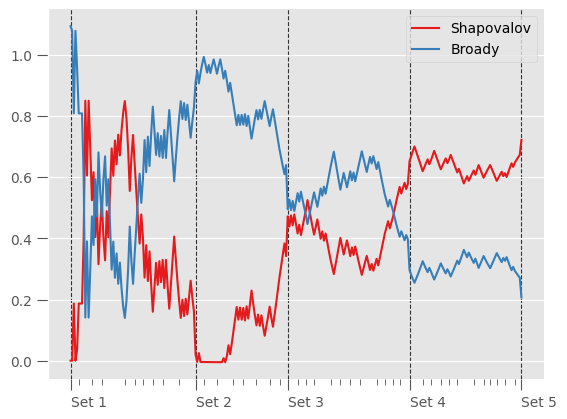

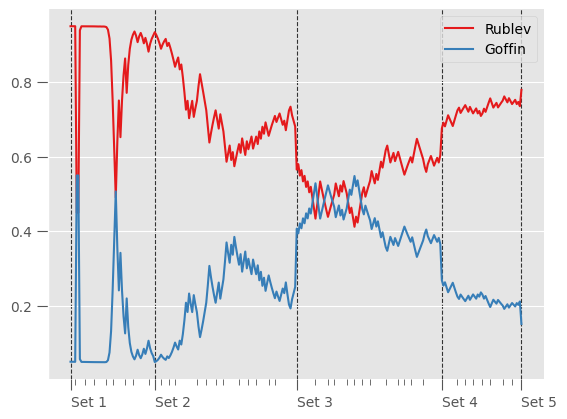

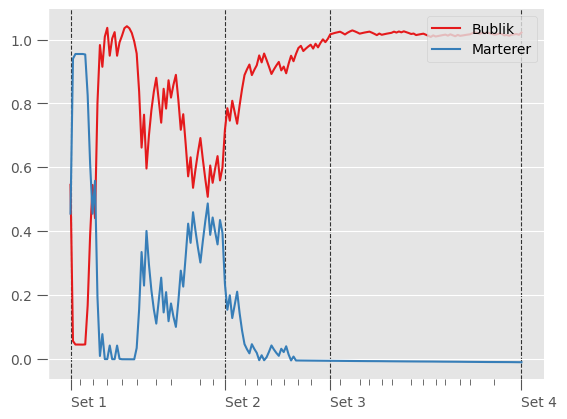

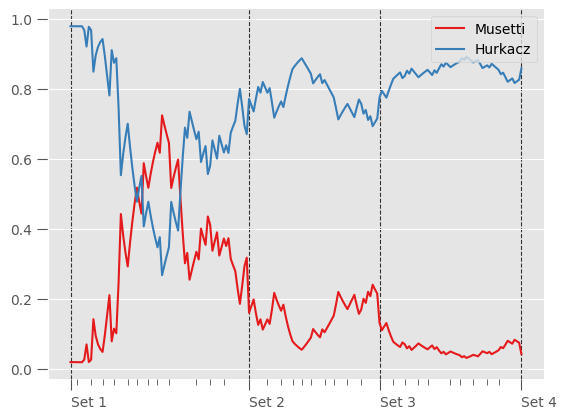

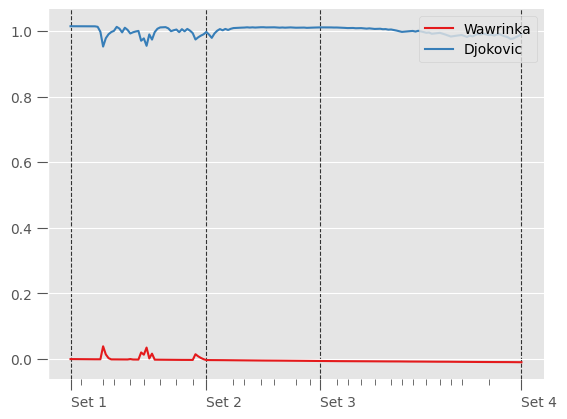

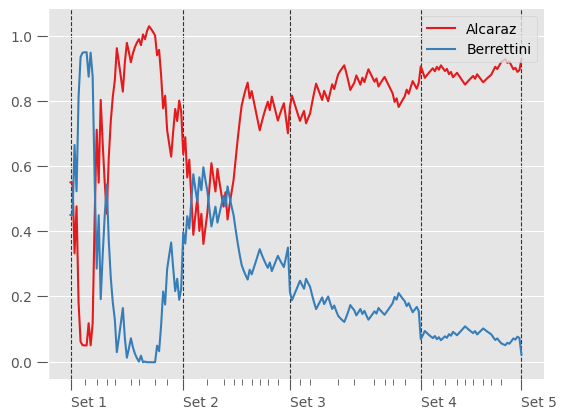

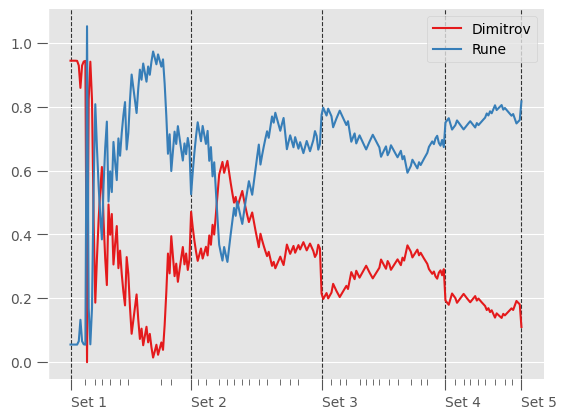

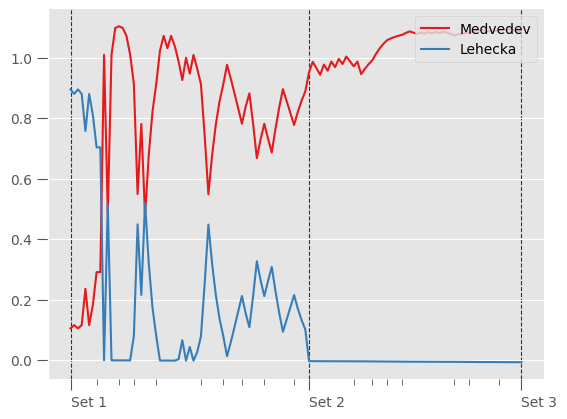

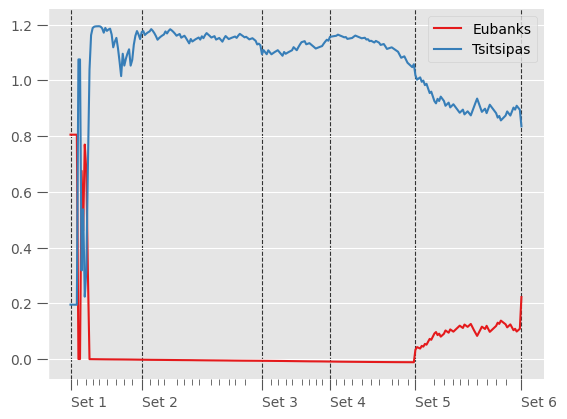

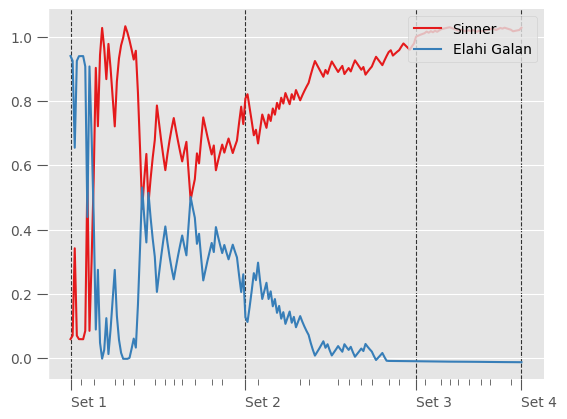

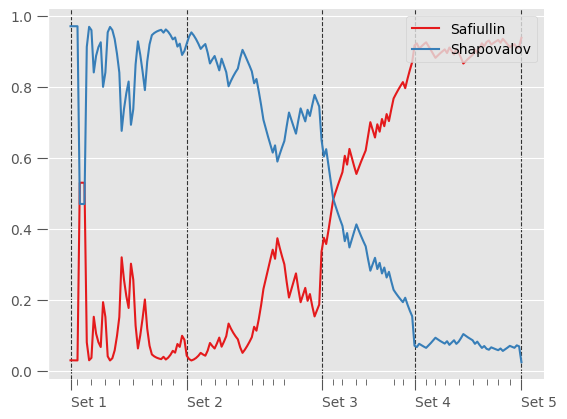

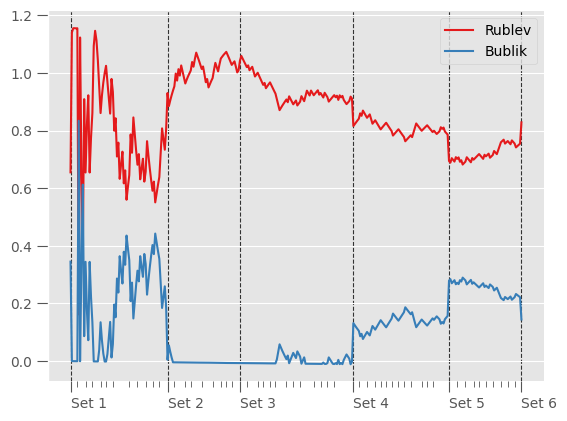

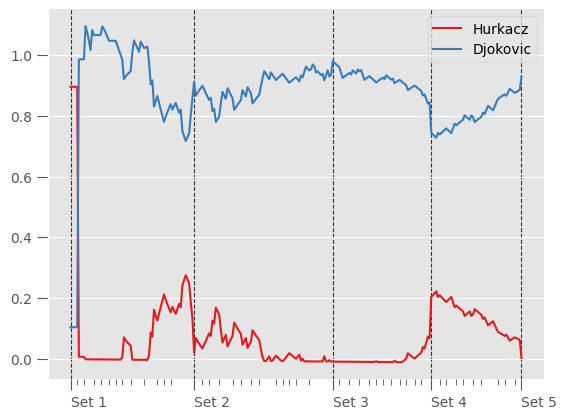

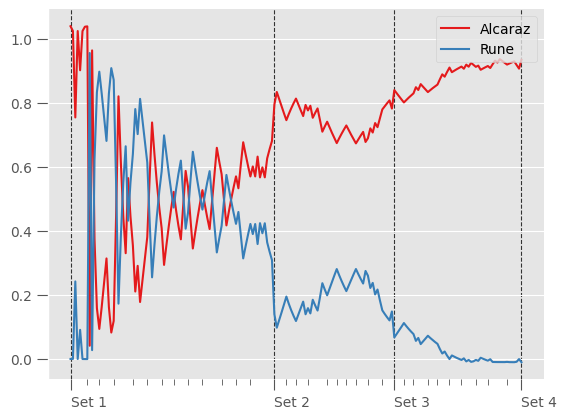

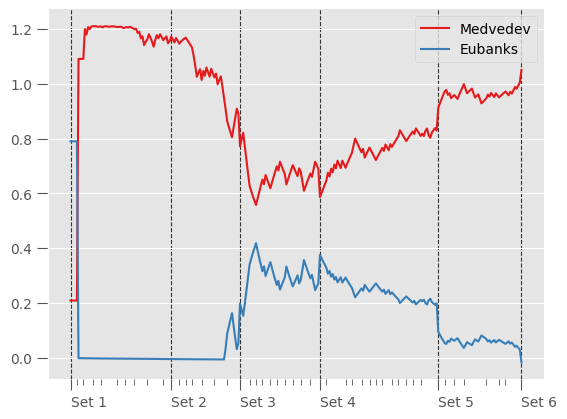

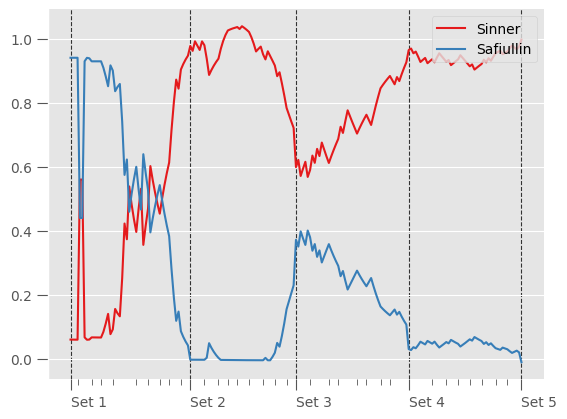

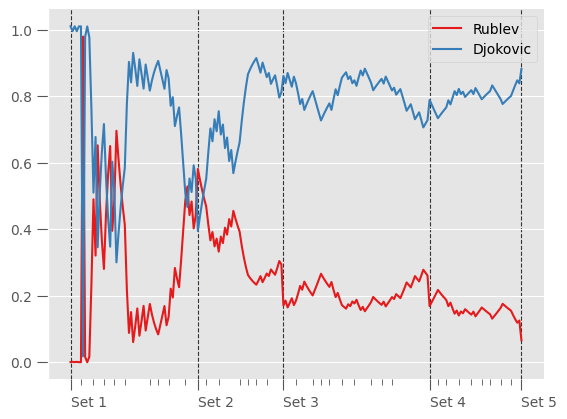

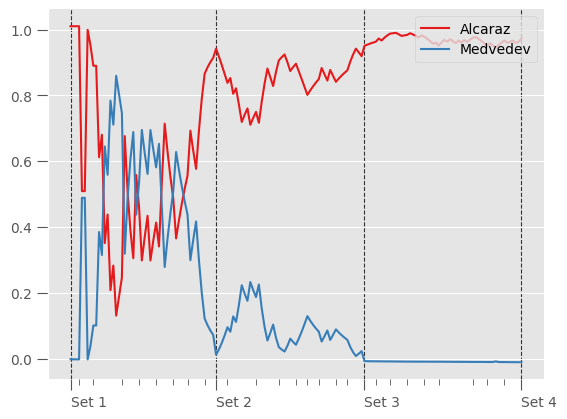

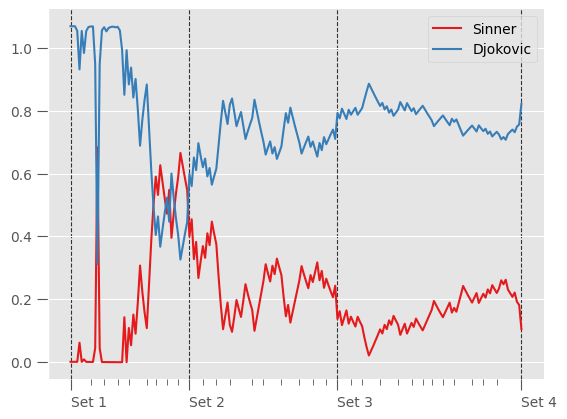

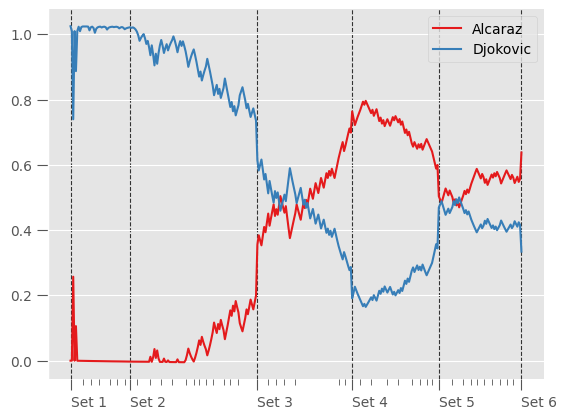

In [16]:
raw_data = tennis_data.load_2023()
MATCHES_TO_EXAMINE = raw_data['match_id'].unique()

set1_correct = set1_total = set2_correct = set2_total = set3_correct = set3_total = set4_correct = set4_total = 0

set5_total = set5_correct = 0

for MATCH_TO_EXAMINE in MATCHES_TO_EXAMINE:
    model = dm1.DynamicTennisModel(raw_data, MATCH_TO_EXAMINE)
    model.fit()
    model.graph_momentum()
    pred = model.prediction()
    result_array = model.evaluate_prediction(pred)

    #print(pred)
    
    try:
        if not np.isnan(pred[0]):
            set1_correct += result_array[0]
            set1_total += 1
        
        if not np.isnan(pred[1]):
            set2_correct += result_array[1]
            set2_total += 1
        if not np.isnan(pred[2]):
            set3_correct += result_array[2]
            set3_total += 1
        if not np.isnan(pred[3]):
            set4_correct += result_array[3]
            set4_total += 1
        if not np.isnan(pred[4]):
            set5_correct += result_array[4]
            set5_total += 1    
    finally:
        continue

print(f"Predicted winner at end of set 1 correctly {set1_correct} / {set1_total} times")
print(f"Predicted winner at end of set 2 correctly {set2_correct} / {set2_total} times")
print(f"Predicted winner at end of set 3 correctly {set3_correct} / {set3_total} times")
print(f"Predicted winner at end of set 4 correctly {set4_correct} / {set4_total} times")
print(f"Predicted winner at end of set 5 correctly {set5_correct} / {set5_total} times")

In [3]:
result_array

array([0, 0, 1, 1, 1])

In [7]:
pred

array([2., 2., 1., 1., 1.])